In [1]:
%matplotlib inline 
import numpy as np 
import os, pickle, time
import pyemma as py 
import mdtraj as md 
import nglview as nv 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 

/opt/anaconda3/envs/PythonGPU/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1.0
 
# Create a session with the above options specified.
#K.tensorflow_backend.set_session(tf.Session(config=config))

/Users/aawad.19/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aawad.19/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aawad.19/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aawad.19/.local/lib/python3.7/site-packages/tensorflow/python/framework/dty

In [4]:
import tensorflow.compat

In [5]:
import sys
sys.path.append('/home/kengyangyao/Dropbox/temp_Linux/temp_research_proj/hde/')
from hde import HDE, MolGen, Propagator

Using TensorFlow backend.


## generate trajectory

In [6]:
trajs_files = ['/home/kengyangyao/data/dataset/1_Trpcage_2JOF/0_simulation/200us_DEShaw/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-%03d.dcd' % item
              for item in range(105)]
trajs_all = [md.load(item, top='/home/kengyangyao/data/dataset/1_Trpcage_2JOF/0_simulation/200us_DEShaw/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein.pdb')
             for item in trajs_files]

In [7]:
traj = md.join(trajs_all)

In [8]:
# traj.save('/tmp/temp_traj.h5')

In [108]:
def get_autocorr(data, lag):
    if type(data) is list or data.ndim == 2:
        temp_pair = (np.concatenate([item_traj[:-lag:lag] for item_traj in data]),
                     np.concatenate([item_traj[lag::lag] for item_traj in data]))
    else:
        temp_pair = (data[:-lag:lag], data[lag::lag])
    return np.corrcoef(temp_pair[0], temp_pair[1])[0][1]

def get_timescales(data, lag):
    return -lag / np.log(get_autocorr(data, lag))

## Prepare trajectory

In [8]:
# trj_dir = "/home/hsidky/Data/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein"
# trj_file = os.path.join(trj_dir, "trp-cage_rmsdmin.dcd")
# pdb_file = os.path.join(trj_dir, "2JOF-0-protein.pdb")

In [9]:
# traj = md.load(trj_file, top=pdb_file)

In [10]:
traj.superpose(traj[0])

<mdtraj.Trajectory with 1044000 frames, 272 atoms, 20 residues, and unitcells at 0x7efe4c2bbe80>

In [11]:
alpha = traj.top.select_atom_indices('alpha')
traj_ca = traj.atom_slice(alpha)

In [12]:
traj_ca.superpose(traj_ca[0])

<mdtraj.Trajectory with 1044000 frames, 20 atoms, 20 residues, and unitcells at 0x7efe4d327fd0>

In [13]:
xyz = traj_ca.xyz.reshape(-1, len(alpha)*3)

In [14]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [15]:
y_train = scaler.fit_transform(xyz)

## Load SRV for reference

In [16]:
with open('lss_files/hde_model_078.pkl', 'rb') as f:
    srv = pickle.load(f)

W0725 17:11:04.854132 139633210132288 deprecation_wrapper.py:119] From /home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 17:11:04.874305 139633210132288 deprecation_wrapper.py:119] From /home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 17:11:04.930959 139633210132288 deprecation_wrapper.py:119] From /home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 17:11:04.931723 139633210132288 deprecation_wrapper.py:119] From /home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placehol

In [15]:
# srv._encoder.summary()

##  Load SRV coordinates

In [18]:
Z = np.load('lss_files/hde_coords.npy')

In [19]:
srv_scaler = MinMaxScaler(feature_range=(-1,1))

In [20]:
x_train = srv_scaler.fit_transform(Z[:,[0,2,3]])

# Fit Generator

In [21]:
molgen = MolGen(
    latent_dim=x_train.shape[1],
    output_dim=y_train.shape[1],
    batch_size=20000,
    noise_dim=100,
    n_epochs=100000,
    hidden_layer_depth=3,
    hidden_size=200,
    n_discriminator=5
)

W0725 17:11:20.603214 139633210132288 deprecation_wrapper.py:119] From /home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               20800     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 60)                12060     
Total params: 113,260
Trainable params: 113,260
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               12800     
_________________________________________________________________
dens

In [20]:
# molgen.fit(x_train, y_train)

In [52]:
#molgen.generator.save('generator.h5')

In [53]:
#molgen.discriminator.save('discriminator.h5')

In [30]:
# with open('trp_cage_molgen.pkl', 'wb') as f:
#     pickle.dump(molgen, f)

In [22]:
from hde.molgen import swish

In [23]:
molgen.generator = tf.keras.models.load_model('lss_files/generator_new_test.h5', custom_objects={'swish': swish})
molgen.discriminator = tf.keras.models.load_model('lss_files/discriminator_new_test.h5', custom_objects={'swish': swish})

W0725 17:11:26.913943 139633210132288 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0725 17:11:27.067951 139633210132288 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


## Propagator

In [24]:
n_mix = 25
lag = 100

In [25]:
prop_scaler = MinMaxScaler(feature_range=(0,1))

In [26]:
traj_prop = x_train

In [27]:
traj_prop_scaled = prop_scaler.fit_transform(traj_prop)

In [28]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, restore_best_weights=True)
]

In [29]:
prop = Propagator(
    traj_prop_scaled.shape[1], 
    n_components=n_mix, 
    lag_time=lag, 
    batch_size=200000, 
    learning_rate=0.0005, 
    n_epochs=20000,
    callbacks=callbacks,
    hidden_size=100,
    activation='relu'
)

W0725 17:11:32.957565 139633210132288 deprecation.py:506] From /home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0725 17:11:33.136126 139633210132288 deprecation.py:323] From /home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0725 17:11:33.147950 139633210132288 deprecation_wrapper.py:119] From /home/kengyangyao/Dropbox/temp_Linux/temp_research_proj/hde/hde/propagator.py:171: The name tf.keras.backend

In [30]:
from hde.propagator import get_mixture_loss_func

In [31]:
prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=0.0001))

Best so far: 
- -11.4 (hidden_size = 100, n_mix = 10)
- -11.65 (hidden_size = 20, n_mix = 20, activation = relu)
- -12.12 (hidden_size = 100, n_mix = 25, activation = relu)

In [32]:
# prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=0.001))
# prop.fit([traj_prop_scaled, traj_prop_scaled[::-1]])

In [33]:
# with open('trp_prop_weights.pkl', 'wb') as f:
#     pickle.dump(prop.model.get_weights(), f)

In [34]:
with open('lss_files/trp_prop_weights_1.pkl', 'rb') as f:
    prop.model.set_weights(pickle.load(f))

## Generate multiple trajectories

In [35]:
# synth_trajs = [prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), 10440).reshape(10440, -1) for _ in range(100)]
# np.save('/home/kengyangyao/data/LSS_paper_files/synth_trajs', synth_trajs)
synth_trajs = np.load('/home/kengyangyao/data/LSS_paper_files/synth_trajs.npy')

In [154]:
def add_label_to_subplot(ax, label, label_font_size=18):
    xlim = ax.get_xlim()
    xlim_width = xlim[1] - xlim[0]
    ylim = ax.get_ylim()
    ylim_width = ylim[1] - ylim[0]
    ax.text(xlim[0] - xlim_width * 0.20, ylim[1] + 0.05 * ylim_width, label,
            fontsize=label_font_size)
    return

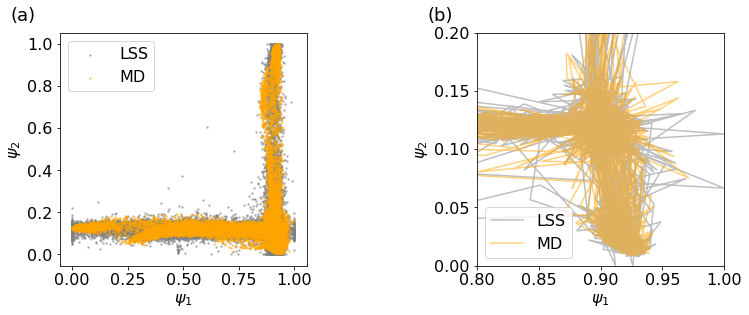

In [184]:
concat_synth_trajs = synth_trajs.reshape(synth_trajs.shape[0] * synth_trajs.shape[1], 3)
subplot_labels = ['(a)', '(b)']
fig, axes = plt.subplots(1, 2)
ax = axes[0]
ax.scatter(concat_synth_trajs[:, 0], concat_synth_trajs[:, 1], s=2, label='LSS', alpha=0.5, c='grey')
ax.scatter(traj_prop_scaled[:, 0], traj_prop_scaled[:, 1], s=2, label='MD', alpha=0.5, c='orange')
ax = axes[1]
ax.plot(synth_trajs[0, :, 0], synth_trajs[0, :, 1], label='LSS', alpha=0.5, c='grey')
ax.plot(traj_prop_scaled[::100, 0], traj_prop_scaled[::100, 1], label='MD', alpha=0.5, c='orange')
ax.set_xlim([0.8, 1.0])
ax.set_ylim([0, 0.2])
for item in range(2):
    axes[item].set_xlabel('$\psi_1$')
    axes[item].set_ylabel('$\psi_2$')
    axes[item].legend()
    add_label_to_subplot(axes[item], subplot_labels[item])
fig.tight_layout()
fig.set_size_inches(12, 5)
fig.savefig('R1.png', bbox_inches='tight')

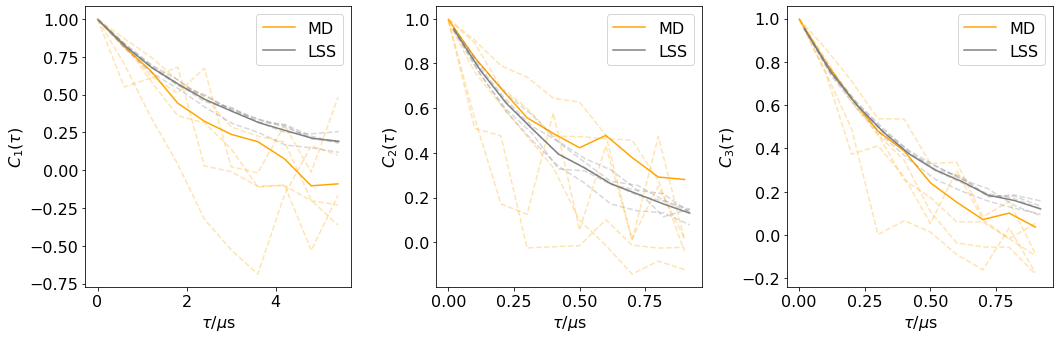

In [182]:
data_for_autocorr = [traj_prop_scaled, synth_trajs]
unit_convert_factor = [5000, 50]
lag_time_max = [6, 1, 1]
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
color_list = ['orange', 'grey']
label_list = ['MD', 'LSS']

from scipy.optimize import curve_fit
def exp_func(lag, temp_t):
    return np.exp(- lag / temp_t)

for item in range(3):
    ax = axes[item]
    for _1 in range(2):
        lag_list = np.array(range(1, lag_time_max[item] * unit_convert_factor[_1], 
                                  lag_time_max[item] * unit_convert_factor[_1] // 10))
        if _1 == 0:
            temp_autocorr = [get_autocorr(traj_prop_scaled[:, item], item_lag) for item_lag in lag_list]
            popt, pcov = curve_fit(exp_func, lag_list / unit_convert_factor[_1], temp_autocorr)
#             print("MD (i = %d): k, t_i, c_i = " % (item + 1), popt)
#             print("MD (i = %d): t_i = " % (item + 1), popt)

            len_block = traj_prop_scaled.shape[0] // 5
            temp_autocorr_block = [[get_autocorr(
                traj_prop_scaled[item_traj * len_block: (item_traj + 1) * len_block, item], item_lag) 
                        for item_lag in lag_list] for item_traj in range(5)]
            
        else:
            temp_autocorr = [get_autocorr(synth_trajs[:, :, item], item_lag) for item_lag in lag_list]
            popt, pcov = curve_fit(exp_func, lag_list / unit_convert_factor[_1], temp_autocorr)
#             print("LSS (i = %d): k, t_i, c_i = " % (item + 1), popt)
#             print("LSS (i = %d): t_i = " % (item + 1), popt)
            len_block = synth_trajs.shape[0] // 5
            temp_autocorr_block = [[get_autocorr(
                synth_trajs[item_traj * len_block: (item_traj + 1) * len_block, :, item], item_lag) 
                        for item_lag in lag_list] for item_traj in range(5)]
        ax.plot(lag_list / unit_convert_factor[_1], temp_autocorr, c=color_list[_1], label=label_list[_1])
        for item_traj in range(5):
            ax.plot(lag_list / unit_convert_factor[_1], temp_autocorr_block[item_traj], '--', alpha=0.3,
                    c=color_list[_1])
        ax.set_xlabel('$\\tau$/$\mu$s')
        ax.set_ylabel('$C_%d(\\tau)$' % (item + 1))
    ax.legend()
fig.tight_layout()
fig.savefig('R2.pdf', bbox_inches='tight')

In [36]:
#x_prop = prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), 10000)
#x_prop = x_prop.reshape(10000, -1)


In [37]:
-lag / np.log(np.corrcoef(traj_prop[:-lag:lag, 0], traj_prop[lag::lag, 0])[0][1]) * 0.2

2934.895660397669

In [38]:
def get_timescales_blocking(trajs, lag_time, num_blocks):
    result = []
    temp_size = trajs.shape[0] // num_blocks
    for item in range(num_blocks):
        temp_traj = trajs[item * temp_size: (item+1) * temp_size]
        if temp_traj.ndim == 1:
            temp_pair = (temp_traj[:-lag_time:lag_time], temp_traj[lag_time::lag_time])
        elif temp_traj.ndim == 2:
            temp_pair = (np.concatenate([item_traj[:-lag_time:lag_time] for item_traj in temp_traj]),
                         np.concatenate([item_traj[lag_time::lag_time] for item_traj in temp_traj]))
        result.append(-lag_time / np.log(np.corrcoef(temp_pair[0], temp_pair[1])[0,1]))
    return np.array(result)

for item in range(3):
    timescales_md = get_timescales_blocking(traj_prop_scaled[:, item], 100, 5)
    print(0.2 * timescales_md.mean(), 0.2 * timescales_md.std())
for item in range(3):
    timescales_lss = get_timescales_blocking(synth_trajs[:,:, item], 1, 5)
    print(100 * 0.2 * timescales_lss.mean(), 100 * 0.2 * timescales_lss.std())

3002.4055790298085 607.5120447311633
538.8966382769858 370.1216786881327
451.9073164106571 118.54539551431435
2889.6879300246073 196.9080844622225
427.03378007403626 37.083230825226586
415.18149996639715 13.312683360352462


In [39]:
np.array(synth_timescales).mean(axis=0), np.array(synth_timescales).std(axis=0)

NameError: name 'synth_timescales' is not defined

In [40]:
synth_timescales = []
for st in synth_trajs:
    
    tss = []
    for i in range(st.shape[1]):
        tc = np.corrcoef(st[:-1:1,i], st[1::1,i])[0,1]
        ts = -lag/np.log(tc)
        tss.append(ts)
    synth_timescales.append(tss)

In [41]:
synth_timescales = np.array(synth_timescales)

In [42]:
ref_timescales = [] 
for i in range(3):
    tc = np.corrcoef(traj_prop_scaled[:-lag:lag,i], traj_prop_scaled[lag::lag,i])[0,1]
    ts = -lag/np.log(tc)
    ref_timescales.append(ts)

ref_timescales = np.array(ref_timescales)

In [43]:
sort_idx = np.argsort(np.sqrt(np.sum((synth_timescales - ref_timescales)**2, axis=1)))

In [44]:
top_synth_trajs = [synth_trajs[i] for i in sort_idx[:10]]  # choose optimal 10 synthetic trajectories

In [45]:
np.mean(synth_timescales[sort_idx[:10]], axis=0)

array([14632.04196742,  2573.17300885,  2073.99267346])

In [46]:
np.std(synth_timescales[sort_idx[:10]], axis=0)

array([591.09821639, 418.25162743, 244.3177718 ])

In [47]:
ref_timescales

array([14674.47839851,  2844.20018763,  2314.54976916])

In [48]:
counts_transitions = np.array([14, 9, 11, 11, 12, 10, 11, 10, 8, 11])
print(counts_transitions.mean(), counts_transitions.std())

10.7 1.5524174696260022


In [49]:
# fig, ax = plt.subplots()
# ax.plot(top_synth_trajs[9][:, 0])
# # ax.plot(traj_prop_scaled[:, 0])
# fig.set_size_inches((15, 5))

## Free energy comparison

In [50]:
best_traj = top_synth_trajs[0]

In [51]:
Ff_s, xf_s = np.histogram(np.concatenate(top_synth_trajs)[:,0], bins=100)
Ff_r, xf_r = np.histogram(traj_prop_scaled[:,0], bins=100)

In [52]:
x_ticks = np.arange(0, 1.01, 0.01)

In [53]:
def uncertaity_with_blocking(data_to_use, num=5):
    fes_list = []
    data_length = data_to_use.shape[0]
    for _1 in range(num):
        itersample = data_to_use[data_length // num * _1: data_length // num * (_1+1)]
        fes_count = np.histogram(itersample, bins=x_ticks, density=False)[0] + 1
        fes_count = fes_count / fes_count.sum()
        fes_list.append(-np.log(fes_count))
    fes_list = np.array(fes_list)
    confidence_interval = np.array([fes_list.mean(axis=0) - 1.96 * fes_list.std(axis=0),
                           fes_list.mean(axis=0) + 1.96 * fes_list.std(axis=0)]).T
    return fes_list, confidence_interval

fes_list_md, confidence_interval_md = uncertaity_with_blocking(traj_prop_scaled[:,0])
fes_list_lss, confidence_interval_lss = uncertaity_with_blocking(np.concatenate(synth_trajs)[:, 0], num=5)

In [54]:
# bootstrap for uncertainty estimation
def bootstrap_for_uncertainty_estimate(data_to_use, num=100):
    fes_list = []
    for _ in range(num):
        itersample = np.random.choice(data_to_use, size=data_to_use.shape, replace=True)
        fes_list.append(-np.log(np.histogram(itersample, bins=x_ticks, density=True)[0]))
    fes_list = np.array(fes_list)
    high_per, low_per = 1 - 0.025, 0.025
    confidence_interval = []
    for item in fes_list.T:
        item.sort()
        nn = len(item)
        low_val, high_val = item[int(np.floor(nn * low_per))], item[int(np.floor(nn * high_per))]
        confidence_interval.append([low_val, high_val])
    confidence_interval = np.array(confidence_interval)
    return fes_list, confidence_interval

# fes_list_md, confidence_interval_md = bootstrap_for_uncertainty_estimate(traj_prop_scaled[:,0])
# fes_list_lss, confidence_interval_lss = bootstrap_for_uncertainty_estimate(np.concatenate(synth_trajs)[:, 0])

In [55]:
np.mean((confidence_interval_md[:, 1] - confidence_interval_md[:, 0]) 
        / (confidence_interval_lss[:, 1] - confidence_interval_lss[:, 0]))

9.575429891648527

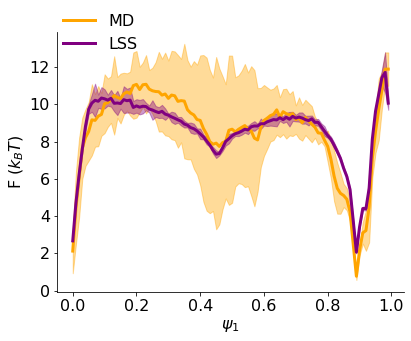

In [56]:
fes_offset = fes_list_md.mean() - fes_list_lss.mean()
fes_list_lss = fes_list_lss + fes_offset
confidence_interval_lss = confidence_interval_lss + fes_offset
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(6, 5))
plt.plot(x_ticks[:-1], np.mean(fes_list_md, axis=0), linewidth=3, color='orange')
plt.plot(x_ticks[:-1], np.mean(fes_list_lss, axis=0), linewidth=3, color='purple')
plt.fill_between(x_ticks[:-1], confidence_interval_md[:, 0], confidence_interval_md[:, 1], alpha=0.4, color='orange')
plt.fill_between(x_ticks[:-1], confidence_interval_lss[:, 0], confidence_interval_lss[:, 1], alpha=0.4, color='purple')
plt.xlabel(r'$\psi_1$')
plt.ylabel('F ($k_BT$)')
i = 0
for spine in plt.gca().spines.values():
    if (i+1) % 2 == 0:
        spine.set_visible(False)
    i += 1
    
plt.legend(['MD', 'LSS'], frameon=False, loc=(0, 0.9))

plt.tight_layout()    
plt.savefig('fes_comparison.png', dpi=300)

In [58]:
# np.sqrt(np.mean((-np.log(Ff_r) - (-np.log(Ff_s)-1.2))**2))

In [59]:
def gen_mol_traj(x_scaled):
    molgen.is_fitted = True
    x_unscaled = prop_scaler.inverse_transform(x_scaled)
    synth = scaler.inverse_transform(molgen.transform(x_unscaled)).reshape(-1, 20, 3)
    gen_traj = traj_ca.slice(range(synth.shape[0]))
    
    for i in range(len(gen_traj)):
        gen_traj.xyz[i] = synth[i] 

    gen_traj.superpose(gen_traj[0])
    
    return gen_traj

In [60]:
def get_closest_frames(val, idx, traj, n=10):
    matches = np.argsort(np.abs(traj[:,idx] - val))
    return matches[:n]

In [61]:
def get_RMSD_within_SRV_range(traj, srv_val, val_lo, val_hi):
    idx = (srv_val > val_lo) & (srv_val < val_hi)
    frames = traj[idx]
    result = np.sqrt(frames.xyz.var(axis=0).sum(axis=1).mean())
    return result

print(get_RMSD_within_SRV_range(traj_ca, traj_prop_scaled[:, 0], 0.4, 0.5))
print(get_RMSD_within_SRV_range(md.join(synth_all_trajs),
                                np.concatenate(synth_trajs)[:, 0], 0.4, 0.5))

0.13786413


NameError: name 'synth_all_trajs' is not defined

Select structures closest to different CV values, then generate ensembles.

First pose

In [62]:
synth_idx = get_closest_frames(0., 0, best_traj)
ref_idx = get_closest_frames(0, 0, traj_prop_scaled)

In [63]:
synth_mol_1 = gen_mol_traj(best_traj[synth_idx])
ref_mol_1 = traj_ca[ref_idx]

In [64]:
np.mean(np.concatenate([md.rmsd(synth_mol_1, ref_mol_1[i]) for i in range(len(ref_mol_1))]))*10 # Angstrom

2.931356132030487

In [65]:
np.mean(md.rmsd(synth_mol_1, ref_mol_1[6]))*10 # Angstrom. Central structure. 

2.8852802515029907

In [66]:
ref_2jof = md.load('2jof.pdb')
ref_2jof = ref_2jof.atom_slice(ref_2jof.top.select_atom_indices('alpha'))
np.mean(md.rmsd(synth_mol_1, ref_2jof))

/home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


0.27009374

In [67]:
synth_mol_1.save_pdb('synth_mol_1.pdb')
ref_mol_1.save_pdb('ref_mol_1.pdb')

Third pose

In [68]:
synth_idx = get_closest_frames(0.45, 0, best_traj)
ref_idx = get_closest_frames(0.45, 0, traj_prop_scaled)

In [69]:
synth_mol_3 = gen_mol_traj(best_traj[synth_idx])
ref_mol_3 = traj_ca[ref_idx]

In [70]:
synth_mol_3.save_pdb('synth_mol_3.pdb')
ref_mol_3.save_pdb('ref_mol_3.pdb')

In [71]:
np.mean(np.concatenate([md.rmsd(synth_mol_3, ref_mol_3[i]) for i in range(len(ref_mol_3))]))*10 # Angstrom

3.7623700499534607

## TICA

In [84]:
import pyemma as py

In [85]:
featurizer = py.coordinates.featurizer(traj_ca.topology)
featurizer.add_distances_ca(periodic=False)

In [86]:
feature_source = py.coordinates.source(traj_ca.xyz, features=featurizer)

In [87]:
feature_data = feature_source.get_output()[0]

In [88]:
tica = py.coordinates.tica(data=feature_data, lag=100, dim=3, kinetic_map=True)

In [89]:
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

In [1]:
synth_all_trajs = [gen_mol_traj(x) for x in synth_trajs]

NameError: name 'synth_trajs' is not defined

In [208]:
synth_full = [x.xyz for x in synth_all_trajs]

In [94]:
py.config.show_progress_bars = False

In [210]:
synth_feat_source = py.coordinates.source(synth_full, features=featurizer)

In [211]:
synth_feature_data = synth_feat_source.get_output()

In [212]:
synth_tica_list = tica.transform(synth_feature_data)
synth_tica_output = np.concatenate(synth_tica_list)

In [229]:
np.array([get_timescales([item[:, _1] for item in synth_tica_list], 1) * 100 for _1 in range(3)]) * 0.2

array([169.21895886,  23.3174048 ,   8.7175949 ])

In [228]:
tica.timescales[:5] * 0.2

array([184.35502397,  62.90570629,  36.84374785,  25.86800806,
        22.96492487])

In [373]:
tica_timescales_blocks_md = np.array([get_timescales_blocking(tica_concatenated[:, ii], lag, 5) for ii in range(3)])
tica_timescales_blocks_lss = np.array([get_timescales_blocking(np.array(synth_tica_list)[:,:,ii], 1, 5) for ii in range(3)])
print(tica_timescales_blocks_md.mean(axis=1) * 0.2, tica_timescales_blocks_md.std(axis=1) * 0.2, 
      tica_timescales_blocks_lss.mean(axis=1) * 20, tica_timescales_blocks_lss.std(axis=1) * 20)

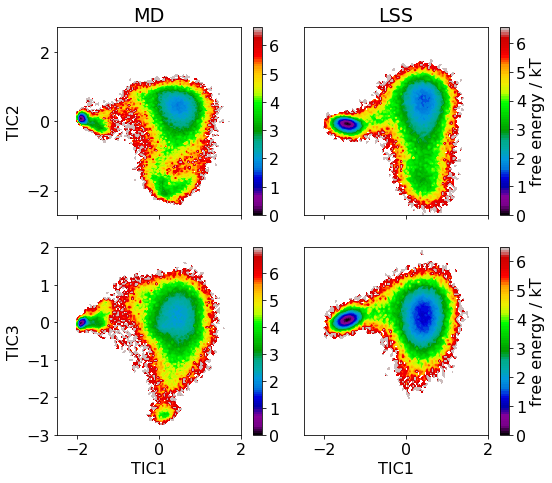

In [226]:
fig, ax = plt.subplots(2, 2, figsize=(8, 7), sharex=True)

y_axes = [(-2.7, 2.7), (-3, 2)]
for i in range(2):
    _, _, misc = py.plots.plot_free_energy(tica_concatenated[::10,0], tica_concatenated[::10,i+1], ax=ax[i,0], cbar_label=None, legacy=False)
    misc['cbar'].set_ticks(np.arange(0, 11))
    _, _, misc = py.plots.plot_free_energy(synth_tica_output[::10,0], synth_tica_output[::10,i+1], ax=ax[i,1], legacy=False)    
    misc['cbar'].set_ticks(np.arange(0, 11))
    ax[i,0].set_ylim(y_axes[i])
    ax[i,1].set_ylim(y_axes[i])
    ax[i,1].set_yticks([])
    ax[i,0].set_xlim([-2.5, 2])
    ax[i,1].set_xlim([-2.5, 2])

ax[0,0].set_title('MD')
ax[0,1].set_title('LSS')
ax[0,0].set_ylabel('TIC2')
ax[1,0].set_xlabel('TIC1')
ax[1,0].set_ylabel('TIC3')
ax[1,1].set_xlabel('TIC1')
plt.tight_layout()
plt.savefig('tica_trpcage.pdf', dpi=300)

In [227]:
# for i, x_dim in enumerate(x_prop.T):
#     plt.hist(2*(x_dim-0.5), bins=100);
#     plt.hist(traj_prop[::100, i], bins=100, alpha=0.5);
#     plt.show()

## Compare timescales

In [277]:
for i in range(3):
    tc = np.corrcoef(traj_prop_scaled[:-lag:lag,i], traj_prop_scaled[lag::lag,i])[0,1]
    ts = -lag/np.log(tc)
    print(f'Reference Timescale {i}: {ts}')
    
    tc = np.corrcoef(x_prop[:-1:1,i], x_prop[1::1,i])[0,1]
    ts = -lag/np.log(tc)

    print(f'Synthetic Timescale {i}: {ts}\n')

Reference Timescale 0: 14674.478398508934


NameError: name 'x_prop' is not defined

In [64]:
srv.timescales_

array([15202.95527403,  5530.1103633 ,  2760.02392811,  2282.64666781,
        1392.44260236,  1167.53880509,   845.65863691])

In [46]:
x_prop_unscaled = prop_scaler.inverse_transform(x_prop)

## Sample molecules

In [48]:
molgen.is_fitted = True

In [54]:
synth = scaler.inverse_transform(molgen.transform(x_prop_unscaled)).reshape(-1, 20, 3)

Using synthetic data, override existing mdtraj struct

In [56]:
gen_traj = traj_ca.slice(range(synth.shape[0]))

In [57]:
for i in range(len(gen_traj)):
    gen_traj.xyz[i] = synth[i] 

In [60]:
gen_traj.superpose(gen_traj[0])

NameError: name 'gen_traj' is not defined

In [59]:
nv.show_mdtraj(gen_traj)

NameError: name 'gen_traj' is not defined

Save trajectory

In [321]:
gen_traj.save_pdb('synthetic_trajectory.pdb')

In [2]:
nv.show_file('synthetic_trajectory.pdb')

NGLWidget()

In [85]:
generated_complete_traj = gen_mol_traj(best_traj)

In [87]:
nv.show_mdtraj(generated_complete_traj)

NGLWidget(count=10000)

## more analysis

In [240]:
real_rg = md.compute_rg(traj_ca)
synth_rg = np.concatenate([md.compute_rg(item) for item in synth_all_trajs])

In [309]:
# _ = plt.hist(real_rg, normed=True, cumulative=True, label='CDF',
#          histtype='step', alpha=0.8, color='k', bins=20)
# _ = plt.hist(synth_rg, normed=True, cumulative=True, label='CDF',
#          histtype='step', alpha=0.8, color='k', bins=20)

In [290]:
print(real_rg.mean(), real_rg.std(), synth_rg.mean(), synth_rg.std())

0.8652388734885347 0.16274522117623383 0.8698104065337168 0.13230689428446393


In [293]:
from scipy.stats import ks_2samp
ks_2samp(real_rg, synth_rg)

Ks_2sampResult(statistic=0.2062183908045977, pvalue=0.0)

/home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kengyangyao/.anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


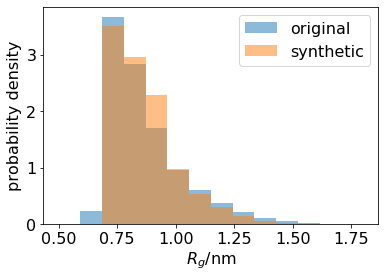

In [299]:
fig, ax = plt.subplots()
hist_bins = np.linspace(0.5, 1.8, 15)
_ = ax.hist(real_rg, alpha=0.5, bins=hist_bins, normed=True, label='original')
_ = ax.hist((synth_rg), alpha=0.5, bins=hist_bins, normed=True, label='synthetic')
ax.legend()
ax.set_xlabel('$R_g$/nm')
ax.set_ylabel('probability density')
fig.savefig('rg_hist.pdf', bbox_inches = 'tight', dpi=300)

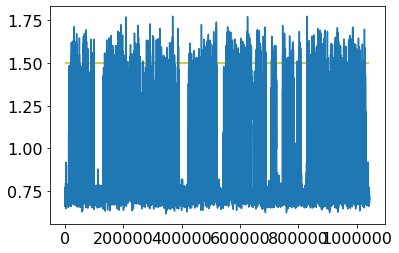

In [243]:
data_to_plot = real_rg
plt.plot(data_to_plot)
plt.hlines(0.7, 0, data_to_plot.shape[0], color='r')
plt.hlines(1.5, 0, data_to_plot.shape[0], color='y')

In [257]:
# compute mean first passage time
def get_state(rg):
    result_states = rg
    result_states[np.where(rg < 0.7)] = 0
    result_states[np.all([0.7 <= real_rg, real_rg < 1.5], axis=0)] = 1
    result_states[np.where(rg >= 1.5)] = 2
    return result_states
    
real_states = get_state(real_rg)

In [267]:
def get_mfpt_list(states_list, current_state):
    mfpt = []
    events = []
    current_idx = 0
    for idx, item in enumerate(states_list):
        if abs(item - current_state) == 2:
            mfpt.append(idx - current_idx)
            events.append([current_idx, idx])
            current_state = item
            current_idx = idx
    return np.array(mfpt), np.array(events)

real_mfpt, events = get_mfpt_list(real_states, 0)

In [258]:
############################

In [342]:
_, dihedrals = md.compute_psi(traj)

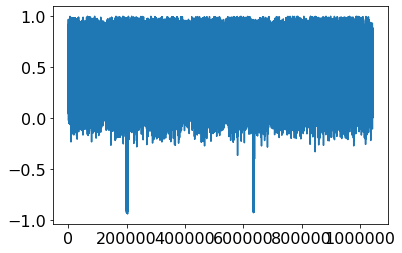

In [351]:
plt.plot(np.sin(dihedrals[:, 17]))